## Customer segmentation based on RFM (Recency Frequency and Monetary gain)

Cluster customers of an online retail store based on Recency Frequency and Monetary value![alt text](https://)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd


In [0]:
df = pd.read_csv("/content/drive/My Drive/Customer Segmentation/OnlineRetail.csv", encoding = "ISO-8859-1")

In [5]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [0]:
# Considering just uk data
df_uk = df[df["Country"] == 'United Kingdom']

In [8]:
df_uk.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
# converting str to date time
df_uk["Date"] = pd.to_datetime(df_uk["InvoiceDate"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_uk = df_uk.drop('InvoiceDate', axis = 1)

### Calculating Recency

Subtract the date of purchase from the most recent date.
Low recency number implies it is closer the most recent purchase 

In [0]:
df_uk = df_uk.reset_index(drop = True)
recent_date = df_uk["Date"].max()
recent_data = df_uk.groupby('CustomerID').Date.max().reset_index()
max_date = recent_data.Date.max()
recent_data["Recency"] = (max_date - recent_data["Date"]).dt.days
recent_data["Recency"] =  recent_data["Recency"].astype(float)

In [18]:
recent_data.describe()

,CustomerID,Recency
count,3950.000000,3950.000000
mean,15562.029367,90.778481
std,1576.848325,100.230349
min,12346.000000,0.000000
25%,14208.250000,16.000000
50%,15571.500000,49.000000
75%,16913.750000,142.000000
max,18287.000000,373.000000


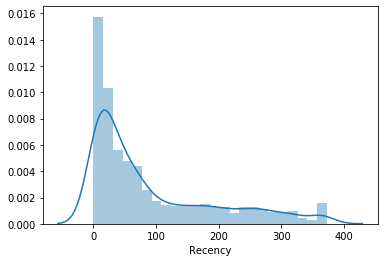

In [20]:
import seaborn as sns
sns.distplot(recent_data["Recency"])

In [0]:
 from sklearn.cluster import KMeans
 import numpy as np
sse = {}
for i in range(1,10):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(recent_data[["Recency"]].astype(float))
  sse[i] = kmeans.inertia_


In [22]:
sse.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

Elbow method to find the optimum number of clusters

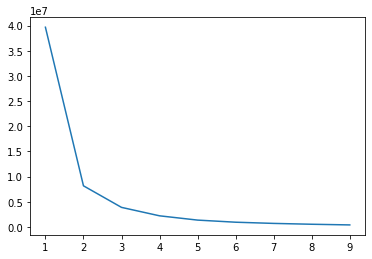

In [23]:
sns.lineplot(list(sse.keys()), list(sse.values()))


In [0]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(recent_data[["Recency"]].astype(float))



In [0]:
recent_data["Recency Cluster"] = kmeans.predict(recent_data[["Recency"]])

Function to assign cluster with highest value in an ascending order. The cluster indexing starts with customers with highest value

In [0]:
def order_cluster(df,cluster_col, prior_col, asc = True):
  new_cluster_col = "New" + cluster_col
  grouped_df = df.groupby(cluster_col)[prior_col].mean().reset_index()
  grouped_df = grouped_df.sort_values(by=prior_col,ascending=asc).reset_index(drop=True)
  grouped_df['index'] = grouped_df.index
  print(grouped_df.head())
  final_df = pd.merge(df, grouped_df[[cluster_col, 'index']], on = cluster_col, how = 'left')
  return final_df


In [30]:
ordered_cluster_recency_df = order_cluster(recent_data, "Recency Cluster", "Recency")

   Recency Cluster     Recency  index
0                2   17.488205      0
1                0   77.679245      1
2                3  184.625000      2
3                1  304.393305      3


In [31]:
ordered_cluster_recency_df.head()

,CustomerID,Date,Recency,Recency Cluster,index
0,12346.0,2011-01-18 10:17:00,325.0,1,3
1,12747.0,2011-12-07 14:34:00,1.0,2,0
2,12748.0,2011-12-09 12:20:00,0.0,2,0
3,12749.0,2011-12-06 09:56:00,3.0,2,0
4,12820.0,2011-12-06 15:12:00,2.0,2,0


In [0]:
import matplotlib.pyplot as plt

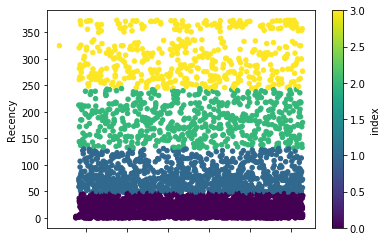

In [39]:
ax1 = ordered_cluster_recency_df.plot.scatter(x='CustomerID',
                      y='Recency',
                      c='index',
                      colormap='viridis')

Revenue

In [32]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00


### Revenue
Calculated as product of quantity and unit price

In [0]:
df_uk["Revenue"] = df_uk["Quantity"] * df_uk["UnitPrice"]

In [0]:
df_revenue = df_uk.groupby('CustomerID')["Revenue"].sum().reset_index()

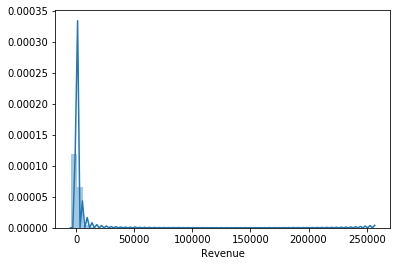

In [68]:
sns.distplot(df_revenue["Revenue"])

In [0]:
sns.hist()

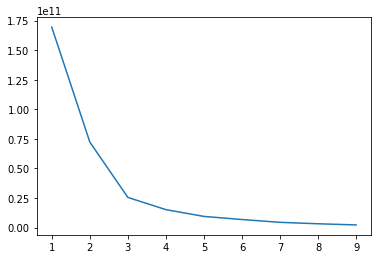

In [138]:
### elbow method to find optimum number of customers
from sklearn.cluster import KMeans
sse = {}
for i in range(1,10):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(df_revenue[["Revenue"]])
  sse[i] = kmeans.inertia_
sns.lineplot(list(sse.keys()), list(sse.values()))

In [0]:
kmeans = KMeans(n_clusters = 4).fit(df_revenue[["Revenue"]])

In [0]:
df_revenue["Revenue Cluster"] = kmeans.predict(df_revenue[["Revenue"]])

High revenue means high value of customer importance. The clusters are assigned in descending order of revenues

In [77]:
df_revenue_ordered = order_cluster(df_revenue,"Revenue Cluster", "Revenue", False)

   Revenue Cluster        Revenue  index
0                1  221960.330000      0
1                3   43070.445185      1
2                0    7760.699530      2
3                2     907.254414      3


In [79]:
df_revenue_ordered

,CustomerID,Revenue,Revenue Cluster,index
0,12346.0,0.00,2,3
1,12747.0,4196.01,2,3
2,12748.0,29072.10,3,1
3,12749.0,3868.20,2,3
4,12820.0,942.34,2,3
...,...,...,...,...
3945,18280.0,180.60,2,3
3946,18281.0,80.82,2,3
3947,18282.0,176.60,2,3
3948,18283.0,2094.88,2,3


In [0]:
df_freq = df_uk.groupby('CustomerID')["InvoiceNo"].count().reset_index()

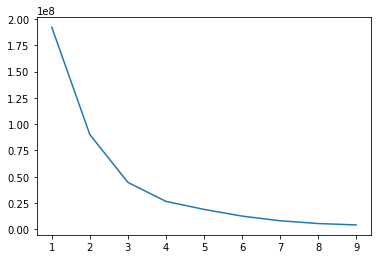

In [83]:
sse = {}
for i in range(1,10):
  kmeans = KMeans(n_clusters = i , random_state = 0).fit(df_freq[["InvoiceNo"]])
  sse[i] = kmeans.inertia_
sns.lineplot(list(sse.keys()), list(sse.values()))

### Frequency
Clusters assigned in descending order of frequency. Higher the frequency higher is the importance.

In [87]:
kmeans = KMeans(n_clusters = 4 , random_state = 0).fit(df_freq[["InvoiceNo"]])
df_freq["Frequency Cluster"] = kmeans.predict(df_freq[["InvoiceNo"]])
df_ordered_freq = order_cluster(df_freq, "Frequency Cluster", "InvoiceNo", False)

   Frequency Cluster    InvoiceNo  index
0                  1  5917.666667      0
1                  3  1313.136364      1
2                  0   331.221445      2
3                  2    49.525744      3


In [89]:
ordered_cluster_recency_df.head(5)

,CustomerID,Date,Recency,Recency Cluster,index
0,12346.0,2011-01-18 10:17:00,325.0,1,3
1,12747.0,2011-12-07 14:34:00,1.0,2,0
2,12748.0,2011-12-09 12:20:00,0.0,2,0
3,12749.0,2011-12-06 09:56:00,3.0,2,0
4,12820.0,2011-12-06 15:12:00,2.0,2,0


In [90]:
df_ordered_freq.head(5)

,CustomerID,InvoiceNo,Frequency Cluster,index
0,12346.0,2,2,3
1,12747.0,103,2,3
2,12748.0,4642,1,0
3,12749.0,231,0,2
4,12820.0,59,2,3


In [91]:
df_revenue_ordered.head(5)

,CustomerID,Revenue,Revenue Cluster,index
0,12346.0,0.00,2,3
1,12747.0,4196.01,2,3
2,12748.0,29072.10,3,1
3,12749.0,3868.20,2,3
4,12820.0,942.34,2,3


In [0]:
ordered_cluster_recency_df = ordered_cluster_recency_df.rename(columns={'index': 'Recency index'})

In [0]:
df_revenue_ordered = df_revenue_ordered.rename(columns = {'index': 'Revenue index'})

In [0]:
df_ordered_freq = df_ordered_freq.rename(columns = {'index': 'Frequency index'})

In [0]:
df_final = pd.merge(ordered_cluster_recency_df[["CustomerID", "Recency", 'Recency index']], df_ordered_freq[["CustomerID", "InvoiceNo", "Frequency index"]], on = "CustomerID")

In [0]:
df_final = pd.merge(df_final , df_revenue_ordered[["CustomerID", "Revenue","Revenue index"]])

In [113]:
df_final.head()

,CustomerID,Recency,Recency index,InvoiceNo,Frequency index,Revenue,Revenue index
0,12346.0,325.0,3,2,3,0.00,3
1,12747.0,1.0,0,103,3,4196.01,3
2,12748.0,0.0,0,4642,0,29072.10,1
3,12749.0,3.0,0,231,2,3868.20,3
4,12820.0,2.0,0,59,3,942.34,3


In [0]:
df_final["Total  Score"] = df_final["Recency index"] + df_final["Revenue index"] + df_final["Frequency index"]

In [118]:
df_final.groupby("Total  Score")["Recency", "InvoiceNo", "Revenue"].mean().reset_index()

,Total Score,Recency,InvoiceNo,Revenue
0,1,1.333333,5917.666667,42177.930000
1,2,1.857143,1272.714286,103954.025714
2,3,7.740741,876.037037,22777.914815
3,4,9.662162,373.290541,9136.946014
4,5,14.892617,271.755034,3607.097114
5,6,20.689610,68.419590,1091.416414
6,7,78.991304,46.963043,868.082991
7,8,185.362989,32.596085,498.087546
8,9,304.584388,21.995781,303.339705


In [128]:
df_final.columns

Index(['CustomerID', 'Recency', 'Recency index', 'InvoiceNo',
       'Frequency index', 'Revenue', 'Revenue index', 'Total  Score',
       'Segment'],
      dtype='object')

In [0]:
df_final["Segment"] = "High Value"

df_final.loc[df_final['Total  Score']>4,'Segment'] = 'Mid-Value' 
df_final.loc[df_final['Total  Score']>6,'Segment'] = 'Low-Value'

In [134]:
df_final.head()

,CustomerID,Recency,Recency index,InvoiceNo,Frequency index,Revenue,Revenue index,Total Score,Segment
0,12346.0,325.0,3,2,3,0.00,3,9,Low-Value
1,12747.0,1.0,0,103,3,4196.01,3,6,Mid-Value
2,12748.0,0.0,0,4642,0,29072.10,1,1,High Value
3,12749.0,3.0,0,231,2,3868.20,3,5,Mid-Value
4,12820.0,2.0,0,59,3,942.34,3,6,Mid-Value


Clusters with high frequency and low value for recency(recent purchase) belong to high valued clusters. 

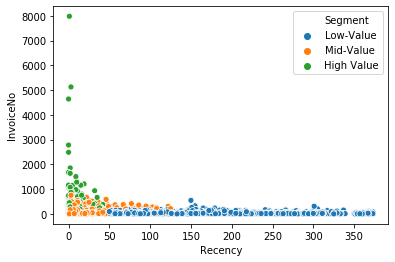

In [135]:
sns.scatterplot(x = "Recency", y ="InvoiceNo", data = df_final, hue = "Segment")

Customers with most recent purchases and high revenue are clustered into high importance cluster

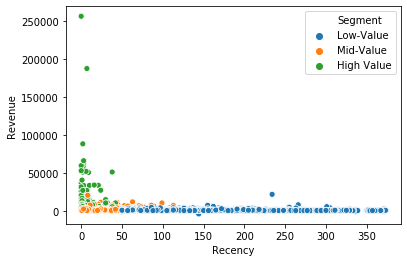

In [136]:
sns.scatterplot(x = "Recency", y ="Revenue", data = df_final, hue = "Segment")

Customers with high frequency and high revenue are clustered as high importance customers

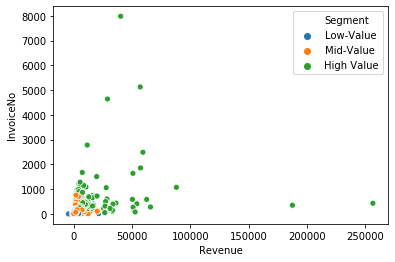

In [137]:
sns.scatterplot(x = "Revenue", y ="InvoiceNo", data = df_final, hue = "Segment")